# Using the cross-entropy to classify MNIST digits

<img src="../NotebooksFigures/mnist_tsne.png" alt="drawing" width="800" >

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [88]:
import numpy as np
from matplotlib import pyplot as plt

In [20]:
import mnist_loader 
training_data, validation_data, test_data = mnist_loader.load_data_wrapper() 

Instantiate network of this form

- 30 hidden neurons
- mini-batch size of 10
- $\eta=0.5$ 

<img src="../NotebooksFigures/tikz12.png" alt="drawing" width="600" >

We will show that the cross-entropy loss function works well

In [79]:
import network2
net = network2.Network([784, 30, 10], cost=network2.CrossEntropyCost)

In [80]:
#?net.large_weight_initializer

In [81]:
net.large_weight_initializer()

In [82]:
epochs = 30
batch_size = 10
learning_rate = 0.5

In [83]:
_, evaluation_accuracy, _, training_accuracy = net.SGD(training_data, epochs, batch_size , learning_rate, 
                                                 evaluation_data=test_data,
                                                 monitor_evaluation_accuracy=True,
                                                 monitor_training_accuracy=True)

Epoch 0 training complete
Accuracy on training data: 45480 / 50000
Accuracy on evaluation data: 9081 / 10000
Epoch 1 training complete
Accuracy on training data: 46565 / 50000
Accuracy on evaluation data: 9273 / 10000
Epoch 2 training complete
Accuracy on training data: 46997 / 50000
Accuracy on evaluation data: 9364 / 10000
Epoch 3 training complete
Accuracy on training data: 47158 / 50000
Accuracy on evaluation data: 9378 / 10000
Epoch 4 training complete
Accuracy on training data: 47470 / 50000
Accuracy on evaluation data: 9436 / 10000
Epoch 5 training complete
Accuracy on training data: 47576 / 50000
Accuracy on evaluation data: 9430 / 10000
Epoch 6 training complete
Accuracy on training data: 47595 / 50000
Accuracy on evaluation data: 9436 / 10000
Epoch 7 training complete
Accuracy on training data: 47790 / 50000
Accuracy on evaluation data: 9447 / 10000
Epoch 8 training complete
Accuracy on training data: 47976 / 50000
Accuracy on evaluation data: 9465 / 10000
Epoch 9 training co

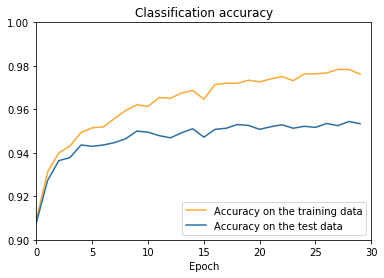

In [84]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.arange(0, epochs, 1), np.array(training_accuracy)/50000, color='#FFA933',
            label="Accuracy on the training data")
ax.plot(np.arange(0, epochs, 1), np.array(evaluation_accuracy)/10000, color='#2A6EA6', 
            label="Accuracy on the test data")
ax.set_xlim(0, epochs)
ax.set_xlabel('Epoch')
ax.set_ylim(0.9, 1)
ax.set_title('Classification accuracy')
plt.legend(loc="lower right")
plt.show()

This shows that the cross-entropy function works well

In [85]:
# save this model in a dictionary with sizes, weights etc...
net.save('net1')
np.save('training_accuracy1.npy', training_accuracy)
np.save('evaluation_accuracy1.npy', evaluation_accuracy)

In [37]:
# how to reload this network

del net

net = network2.load('net1')

# Overfitting


We explain now how to create a situation where our network does a bad job generalizing to new situations.
The training is on a small subset of the data so that the network overfits.

Launch the script overfitting.py

- same network
- training on 1000 images 
- 400 epochs

If we do that ...


<img src="../NotebooksFigures/overfitting1.png" alt="drawing" width="600" >


<img src="../NotebooksFigures/overfitting2.png" alt="drawing" width="600" >

we realize that around epoch $\sim 280$ the network overfits : "what our network learns after epoch 280 no longer generalizes to the test data"

Looking at the test accuracy :

<img src="../NotebooksFigures/overfitting4.png" alt="drawing" width="600" >

we can see that the network is memorizing the training set ($100 \%$ accuracy), without understanding the structure of the data ($\sim 82 \%$ accuracy on the test set)

# How to cure overfitting : regularization techniques

- Early stopping
- Weight decay
- Dropout (will be explained theoretically and used practically in Lecture 3)
- Data augmentation

### Early stopping


We keep track of accuracy on the validation data.
Once the accuracy on the validation_data has saturated, we stop training. 
This strategy is called *early stopping* and could be implemented in many
ways : this require experimentation and common sense.

In the following picture an idealized situation is depicted

<img src="../NotebooksFigures/early_stopping.png" alt="drawing" width="400" >


but in reality there are fluctuations, plateaus etc.

Validation data is used in general to determine the hyper-parameters such as:

- number of epochs of training
- learning rate
- architecture

and also (see below)

- weight decay constant
- dropout level 

This is important in order to avoid overfitting hyper-parameters to the test data !

### Exercise : early stopping

Implement a version of the early stopping using the same architecture, learning
rate and batch size. Look at the accuracy on the validation
data, define a suitable criterion (this will be a matter of your judgement)
and determine the optimal under your criterion number of training epochs.

This is an open exercise, there is not a single solution !

`import mnist_loader
 training_data, validation_data, test_data = mnist_loader.load_data_wrapper()
 ...
 ...`

Let us look again at the accuracies on training and test set we computed before 

<img src="../NotebooksFigures/early_stopping1.png" alt="drawing" width="400" >


Overfitting is much less than in the case in which we train on 1000 images, but it's still there.

This suggests that a strategy to reduce overfitting is to increase the size of the training data, 
also in somewhat artificial ways like data *augmentation*.

Before using again the whole dataset and/or seeing how to use more data artificially augmenting
our dataset we will apply a regularization technique with our small dataset and see how much it
improves our results. Then we will apply it to the whole dataset.

### Weight decay

In [52]:
TRAIN = False
epochs = 400

if TRAIN:
    training_data, validation_data, test_data = mnist_loader.load_data_wrapper() 
    training_data = list(training_data)
    validation_data = list(validation_data)
    test_data = list(test_data)
    net = network2.Network([784, 30, 10], cost=network2.CrossEntropyCost)
    net.large_weight_initializer()
    _, evaluation_accuracy, _, training_accuracy = net.SGD(training_data[:1000], epochs, 10, 0.5, 
                                                           evaluation_data=test_data, lmbda = 0.1,
                                                           monitor_evaluation_cost=True, monitor_evaluation_accuracy=True,
                                                           monitor_training_cost=True, monitor_training_accuracy=True)

    net.save('net2')
    np.save('training_accuracy2.npy', training_accuracy)
    np.save('evaluation_accuracy2.npy', evaluation_accuracy)
else:
    net = network2.load('net2')
    training_accuracy = np.load('training_accuracy2.npy')
    evaluation_accuracy = np.load('evaluation_accuracy2.npy')

Epoch 0 training complete
Cost on training data: 3.1209843611275243
Accuracy on training data: 647 / 1000
Cost on evaluation data: 2.4487577389523727
Accuracy on evaluation data: 5475 / 10000
Epoch 1 training complete
Cost on training data: 2.5311550532171365
Accuracy on training data: 777 / 1000
Cost on evaluation data: 1.9175312874207149
Accuracy on evaluation data: 6705 / 10000
Epoch 2 training complete
Cost on training data: 2.2002948833060727
Accuracy on training data: 843 / 1000
Cost on evaluation data: 1.6605932692236942
Accuracy on evaluation data: 7223 / 10000
Epoch 3 training complete
Cost on training data: 2.0370352889006935
Accuracy on training data: 863 / 1000
Cost on evaluation data: 1.617649674029236
Accuracy on evaluation data: 7378 / 10000
Epoch 4 training complete
Cost on training data: 1.895590021849507
Accuracy on training data: 889 / 1000
Cost on evaluation data: 1.5034549920341806
Accuracy on evaluation data: 7560 / 10000
Epoch 5 training complete
Cost on training

Cost on evaluation data: 1.3158893967035992
Accuracy on evaluation data: 8244 / 10000
Epoch 43 training complete
Cost on training data: 0.8753424654343996
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 1.31707645250265
Accuracy on evaluation data: 8239 / 10000
Epoch 44 training complete
Cost on training data: 0.8671813792119839
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 1.321133124010011
Accuracy on evaluation data: 8241 / 10000
Epoch 45 training complete
Cost on training data: 0.8584896548769837
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 1.317466663590261
Accuracy on evaluation data: 8252 / 10000
Epoch 46 training complete
Cost on training data: 0.8509711400018583
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 1.3187660110581998
Accuracy on evaluation data: 8247 / 10000
Epoch 47 training complete
Cost on training data: 0.8426071524386164
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 1.3088738

Cost on training data: 0.6012965659018765
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 1.2421131388734168
Accuracy on evaluation data: 8335 / 10000
Epoch 86 training complete
Cost on training data: 0.5964479999402043
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 1.2429460237844854
Accuracy on evaluation data: 8349 / 10000
Epoch 87 training complete
Cost on training data: 0.5911956747670825
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 1.2394869378875892
Accuracy on evaluation data: 8342 / 10000
Epoch 88 training complete
Cost on training data: 0.5864210222226254
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 1.234271412415305
Accuracy on evaluation data: 8363 / 10000
Epoch 89 training complete
Cost on training data: 0.5812602948469923
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 1.23565260347278
Accuracy on evaluation data: 8351 / 10000
Epoch 90 training complete
Cost on training data: 0.57657380

Cost on evaluation data: 1.1445815715987395
Accuracy on evaluation data: 8457 / 10000
Epoch 128 training complete
Cost on training data: 0.4237880049596185
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 1.1453101417556755
Accuracy on evaluation data: 8466 / 10000
Epoch 129 training complete
Cost on training data: 0.42065958807498105
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 1.1429039039963427
Accuracy on evaluation data: 8454 / 10000
Epoch 130 training complete
Cost on training data: 0.4172466241909182
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 1.1350909604873611
Accuracy on evaluation data: 8465 / 10000
Epoch 131 training complete
Cost on training data: 0.4142071951477172
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 1.1474325044659757
Accuracy on evaluation data: 8472 / 10000
Epoch 132 training complete
Cost on training data: 0.41092632702833376
Accuracy on training data: 1000 / 1000
Cost on evaluation data

Accuracy on evaluation data: 8549 / 10000
Epoch 170 training complete
Cost on training data: 0.3102927222653711
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 1.0552672638425427
Accuracy on evaluation data: 8557 / 10000
Epoch 171 training complete
Cost on training data: 0.3082851100991388
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 1.0585616398536648
Accuracy on evaluation data: 8553 / 10000
Epoch 172 training complete
Cost on training data: 0.30592630619262184
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 1.0562063897150864
Accuracy on evaluation data: 8566 / 10000
Epoch 173 training complete
Cost on training data: 0.3040629899144577
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 1.0533603090206798
Accuracy on evaluation data: 8578 / 10000
Epoch 174 training complete
Cost on training data: 0.30178754752200504
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 1.058090871042172
Accuracy on evaluation d

Accuracy on evaluation data: 8633 / 10000
Epoch 212 training complete
Cost on training data: 0.2356511040690983
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.9980970676896015
Accuracy on evaluation data: 8639 / 10000
Epoch 213 training complete
Cost on training data: 0.2342813480195287
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.9931562033597358
Accuracy on evaluation data: 8649 / 10000
Epoch 214 training complete
Cost on training data: 0.2327885917460339
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.9979735047393463
Accuracy on evaluation data: 8641 / 10000
Epoch 215 training complete
Cost on training data: 0.2313994256576322
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.9965701241244169
Accuracy on evaluation data: 8645 / 10000
Epoch 216 training complete
Cost on training data: 0.23007161376284888
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.9959760083374445
Accuracy on evaluation d

Accuracy on evaluation data: 8681 / 10000
Epoch 254 training complete
Cost on training data: 0.18651912434436818
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.9553561498666674
Accuracy on evaluation data: 8668 / 10000
Epoch 255 training complete
Cost on training data: 0.18559875074158722
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.9546377440072542
Accuracy on evaluation data: 8664 / 10000
Epoch 256 training complete
Cost on training data: 0.18470571436741234
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.9561637975605528
Accuracy on evaluation data: 8676 / 10000
Epoch 257 training complete
Cost on training data: 0.18376316471241028
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.947599632365594
Accuracy on evaluation data: 8683 / 10000
Epoch 258 training complete
Cost on training data: 0.1828714763242678
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.9514087044476451
Accuracy on evaluation

Accuracy on evaluation data: 8689 / 10000
Epoch 296 training complete
Cost on training data: 0.1541379154008371
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.9264275916064588
Accuracy on evaluation data: 8698 / 10000
Epoch 297 training complete
Cost on training data: 0.1537711983076611
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.9155954766020374
Accuracy on evaluation data: 8705 / 10000
Epoch 298 training complete
Cost on training data: 0.15317008756697625
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.9253604415276387
Accuracy on evaluation data: 8712 / 10000
Epoch 299 training complete
Cost on training data: 0.15252498320012894
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.9207490504356768
Accuracy on evaluation data: 8708 / 10000
Epoch 300 training complete
Cost on training data: 0.15168024618604672
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.9232505613584329
Accuracy on evaluation

Accuracy on evaluation data: 8726 / 10000
Epoch 338 training complete
Cost on training data: 0.13298090543061158
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.9063667243628716
Accuracy on evaluation data: 8714 / 10000
Epoch 339 training complete
Cost on training data: 0.13239285954780547
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.9012859138568207
Accuracy on evaluation data: 8733 / 10000
Epoch 340 training complete
Cost on training data: 0.13209981204533158
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.9116110675406398
Accuracy on evaluation data: 8712 / 10000
Epoch 341 training complete
Cost on training data: 0.13148526991060985
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.9077692455582105
Accuracy on evaluation data: 8727 / 10000
Epoch 342 training complete
Cost on training data: 0.1312283045810108
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.9077872920450528
Accuracy on evaluatio

Accuracy on evaluation data: 8733 / 10000
Epoch 380 training complete
Cost on training data: 0.11842324831550674
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.8872801589428188
Accuracy on evaluation data: 8729 / 10000
Epoch 381 training complete
Cost on training data: 0.11813479940786524
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.8856062649569668
Accuracy on evaluation data: 8737 / 10000
Epoch 382 training complete
Cost on training data: 0.11783806081370064
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.892781364217401
Accuracy on evaluation data: 8735 / 10000
Epoch 383 training complete
Cost on training data: 0.11772560884905195
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.8848166758996637
Accuracy on evaluation data: 8750 / 10000
Epoch 384 training complete
Cost on training data: 0.1173057770937115
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 0.8921509123719087
Accuracy on evaluation

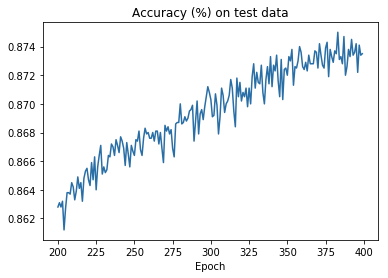

In [78]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.arange(200, epochs, 1), np.array(evaluation_accuracy)[200:]/10000, color='#2A6EA6', 
            label="Accuracy on the test data")
ax.set_xlabel('Epoch')
ax.set_title('Accuracy (%) on test data')
plt.show()

We see that the use of $L_2$ regularization has suppressed overfitting.
Accuracy gets better $\sim 82 \% \rightarrow \sim 87 \%$

Now we go back to the initial situation with the complete training dataset and
see how much we can improve.

Notice that we have to change the weight decay coefficient lambda : can you see why ?
Hint : take a look at the modified learning rule.

In [87]:
TRAIN = False
epochs = 30
batch_size = 10
learning_rate = 0.5
lmbda = 5.0

if TRAIN:
    training_data, validation_data, test_data = mnist_loader.load_data_wrapper() 
    training_data = list(training_data)
    validation_data = list(validation_data)
    test_data = list(test_data)
    net = network2.Network([784, 30, 10], cost=network2.CrossEntropyCost)
    net.large_weight_initializer()
    
    
    _, evaluation_accuracy, _, training_accuracy = net.SGD(training_data, epochs, batch_size , learning_rate, 
                                                 evaluation_data=test_data,
                                                 lmbda = lmbda,
                                                 #monitor_evaluation_cost=True, 
                                                 monitor_evaluation_accuracy=True,
                                                 #monitor_training_cost=True, 
                                                 monitor_training_accuracy=True)
    

    net.save('net3')
    np.save('training_accuracy3.npy', training_accuracy)
    np.save('evaluation_accuracy3.npy', evaluation_accuracy)
else:
    net = network2.load('net3')
    training_accuracy = np.load('training_accuracy3.npy')
    evaluation_accuracy = np.load('evaluation_accuracy3.npy')

Epoch 0 training complete
Accuracy on training data: 45615 / 50000
Accuracy on evaluation data: 9128 / 10000
Epoch 1 training complete
Accuracy on training data: 46768 / 50000
Accuracy on evaluation data: 9307 / 10000
Epoch 2 training complete
Accuracy on training data: 47167 / 50000
Accuracy on evaluation data: 9389 / 10000
Epoch 3 training complete
Accuracy on training data: 47604 / 50000
Accuracy on evaluation data: 9464 / 10000
Epoch 4 training complete
Accuracy on training data: 47712 / 50000
Accuracy on evaluation data: 9480 / 10000
Epoch 5 training complete
Accuracy on training data: 48007 / 50000
Accuracy on evaluation data: 9546 / 10000
Epoch 6 training complete
Accuracy on training data: 48037 / 50000
Accuracy on evaluation data: 9554 / 10000
Epoch 7 training complete
Accuracy on training data: 48193 / 50000
Accuracy on evaluation data: 9546 / 10000
Epoch 8 training complete
Accuracy on training data: 47886 / 50000
Accuracy on evaluation data: 9489 / 10000
Epoch 9 training co

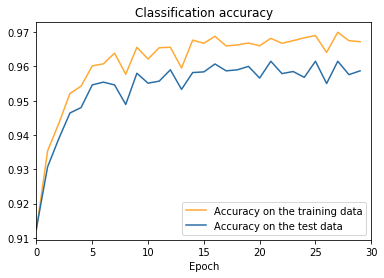

In [94]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.arange(0, epochs, 1), np.array(training_accuracy)/50000, color='#FFA933',
            label="Accuracy on the training data")
ax.plot(np.arange(0, epochs, 1), np.array(evaluation_accuracy)/10000, color='#2A6EA6', 
            label="Accuracy on the test data")
ax.set_xlim(0, epochs)
ax.set_xlabel('Epoch')
ax.set_title('Classification accuracy')
plt.legend(loc="lower right")
plt.show()

The accuracy on the test data improved and the gap between the accuracy on test and train data
is narrower (it is now $\sim 1 \%$, it was $\sim 2 \%$ without regularization)

### Exercises 

- 1. Do the same with the network with 100 neurons.

- 2. (Reading) : read the discussion of further benefits of regularization at the end of the corresponding paragraph in Nielsen's book (it is worth it !)

- 3. Consider the $L_1$ regularization. Derive the learning rule and provide an heuristic argument 
to show that $L_1$ regularization "tends to concentrate the weights of the network in a relatively small number of high-importance connections, while the other weights are driven toward zero."

# Data augmentation


Exercise : run more_data.py in from your terminal

`$ python3 more_data.py`

This will take a while (maybe hours) and it is not necessary that we wait its completion. 
You can play with it whenever you desire.

We will describe now the results.

<img src="more_data_1.png" alt="drawing" width="400" >


<img src="more_data_2.png" alt="drawing" width="400" >


<img src="more_data_3.png" alt="drawing" width="400" >
